<a href="https://colab.research.google.com/github/shivammehta007/NLPResearch/blob/master/Comparison_of_NLP_Models_IMDB_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# We will compare NLP Models with IMDB Classification

## Imports

In [57]:
import os
import re
import random

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchtext

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import spacy
from collections import namedtuple
from pprint import pprint

!pip install -U tqdm
# Need to restart runtime on google collab for it to work

from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ParameterGrid
from tqdm.notebook import tqdm
from torchtext import datasets
from torchtext import data

# Create a Tokenizer with the default settings for English
# including punctuation rules and exceptions
spacy_en = spacy.load('en')
%matplotlib inline

Requirement already up-to-date: tqdm in /usr/local/lib/python3.6/dist-packages (4.42.0)


## Seed Set

In [0]:
SEED = 1234

torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
np.random.seed(SEED)
torch.backends.cudnn.deterministic = True
random.seed(SEED)

# Load the Data

## PreProcessing Functions

#### Steps:

1.   Decontract
2.   Stopwords Removal
3.   Punctuation Removal


##### 1. Decontract

In [0]:
def decontracted(text):
    # specific
    text = re.sub(r"won't", "will not", text)
    text = re.sub(r"can\'t", "can not", text)

    # general
    text = re.sub(r"n\'t", " not", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"\'s", " is", text)
    text = re.sub(r"\'d", " would", text)
    text = re.sub(r"\'ll", " will", text)
    text = re.sub(r"\'t", " not", text)
    text = re.sub(r"\'ve", " have", text)
    text = re.sub(r"\'m", " am", text)
    return text

##### 2. Stopwords Removal

In [4]:
import nltk
from nltk.corpus import stopwords
nltk.download("stopwords")

stopwords = set(stopwords.words("english")) | set(["br"])

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


##### 3. Punctuation Removal

In [0]:
from string import punctuation

def remove_punctuation(text):
    text = text.translate(str.maketrans('', '', punctuation))
    return text

## TorchText Data

Initialize two Field and Label 

### Creating Tokenizer

In [0]:
def tokenizer(text):
    """Tokenize and do an Early PreProcessing"""
    text = decontracted(text)
    text = remove_punctuation(text)
    return [word.text.lower() for word in spacy_en.tokenizer(text) if word.text.lower() not in stopwords]


In [0]:
TEXT = data.Field(tokenize=tokenizer, include_lengths=True)
LABEL = data.LabelField(dtype = torch.float)

In [0]:
%%time
train_data, test_data = datasets.IMDB.splits(TEXT, LABEL)

aclImdb_v1.tar.gz:   0%|          | 0.00/84.1M [00:00<?, ?B/s]

downloading aclImdb_v1.tar.gz


aclImdb_v1.tar.gz: 100%|██████████| 84.1M/84.1M [00:02<00:00, 41.3MB/s]


CPU times: user 1min 50s, sys: 10.5 s, total: 2min
Wall time: 2min 2s


In [0]:
print(len(train_data), len(test_data))
print(vars(train_data.examples[0]))

25000 25000
{'text': ['diagnosis', 'murder', 'shown', 'weekday', 'afternoons', 'bbc1', 'since', 'used', 'watch', 'ill', 'school', 'good', '10', 'years', 'ago', ' ', 'know', 'really', 'enjoy', 'way', 'enjoy', 'murder', 'wrote', 'totally', 'addicted', 'even', 'dvd', 'boxsetsok', 'know', 'sadbr', 'dick', 'van', 'dyke', 'carries', 'show', 'stars', 'drmark', 'sloan', 'doctor', 'community', 'general', 'hospital', 'la', 'also', 'police', 'consultant', 'lapd', ' ', 'son', 'steve', 'barry', 'van', 'dyke', ' ', 'dick', 'real', 'life', 'son', 'police', 'officer', 'needs', 'father', 'help', 'many', 'suspicious', 'deaths', 'along', 'ride', 'dramanda', 'bentley', 'victoria', 'bentley', 'resident', 'pathologist', 'community', 'general', 'first', 'couple', 'seasons', 'scott', 'baio', 'playing', 'drjack', 'stewart', 'upped', 'left', 'series', '1995', 'hoping', 'go', 'bigger', 'better', 'thingshe', 'stayed', 'done', 'anything', 'note', 'sinceand', 'theatrical', 'appearance', 'many', 'years', 'baby', 'ge

In [0]:
train_data, valid_data = train_data.split(split_ratio=0.8, random_state=random.seed(SEED))

In [0]:
print(f'Train Data: \t\t {len(train_data):,}')
print(f'Validation Dataset: \t {len(valid_data):,}')
print(f'Test Data: \t\t {len(test_data):,}')

Train Data: 		 20,000
Validation Dataset: 	 5,000
Test Data: 		 25,000


## Pandas DataFrame
We Converted Data to DataFrame for implementation of Classical Algorithms

In [0]:
type(train_data.examples[0].text)

list

In [0]:
def get_dataframe_from_dataset(dataset, labels = {'X': 'text', 'y': 'label'}):
    """Utility Method to convert torchext.data.Dataset to numpy array of text and label"""
    i = 0
    data = {'X' : [], 'y' : []}
    for example in tqdm(dataset):
        data['X'].append(' '.join(example.text))
        data['y'].append(example.label)
    
    assert len(data['X']) == len(data['y'])

    return pd.DataFrame(data).rename(columns=labels)


In [0]:
train_df = get_dataframe_from_dataset(train_data)
val_df = get_dataframe_from_dataset(valid_data)
test_df = get_dataframe_from_dataset(test_data)

In [0]:
test_df.head()

,text,label
0,1850 yorkshire boy chimneysweep falsely accuse...,pos
1,film partly thriller partly publicservice anno...,pos
2,even decade frontline aired abc near tell curr...,pos
3,amazed quality film particularly seeing pictur...,pos
4,felt way saw episode original run still agree ...,pos


# Implementation


## Classical ML algorithms

First Step will be **Preprocessing**
### List of Algorithms Implemented
1.   Naïve Bais Classifier
2.   Random Forest Classifier
3.   Support Vector Machines (SVM) Linear
4.   SGD Classifiers
5.   XGBoost
6.   Lightgbm



## Vectorize Data

In [0]:
dataframes = [train_df, val_df, test_df]

##### 1. Vectorize
from Sklearn.feature_extraction.text import:
1.   CountVectorizer
2.   TfIdfVectorizer



In [0]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

We will use them later ! In sklearn.pipeline.Pipleline !!

##### 2. Encode Label

In [0]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

In [0]:
for df in tqdm(dataframes):
    df['label'] = le.fit_transform(df['label'])

In [0]:
train_df.head()

,text,label
0,margret laurence probably intend novels adopte...,0
1,movie made feel like feel bad like want money ...,1
2,brilliant russian émigré devises stanislavsky...,1
3,hard say sometimes exactly film effective mome...,1
4,seen movie many times recently read book movie...,0


#### Converting to Numpy arrays 
For faster computation and generic variable names

In [0]:
split_df = lambda df: (np.array(df['text']), np.array(df['label']))

In [0]:
X_train, y_train = split_df(train_df)
X_valid, y_valid = split_df(val_df)
X_test, y_test = split_df(test_df)

### Pipeline of Algorithms

#### Support Methods

In [0]:
def get_predictions_and_accuracy(X_test):
    y_pred = best_model.pipeline.predict(X_test)
    test_accuracy = accuracy_score(y_test, y_pred)
    print('Test Accuracy: {:.4f}%'.format(test_accuracy * 100))
    report = pd.DataFrame(classification_report(y_pred, y_test, target_names=['neg', 'pos'], output_dict=True))
    print(report)
    sns.heatmap(report.iloc[:-1:].T, annot=True)
    plt.title('Classification Report')
    plt.show()

In [0]:
from sklearn.pipeline import Pipeline

In [0]:
Model = namedtuple('Model', ['pipeline', 'predictions', 'accuracy'])

#### 1. Naïve Bais Classifier

In [0]:
from sklearn.naive_bayes import MultinomialNB

##### Generating Pipelines
Generate two pipelines with differenet Vectorizers, whichever will show better performance over valid set, we will tune Hyperparameters over it

In [0]:
naive_bais1 = Pipeline(
    [('cv', CountVectorizer()),
      ('nb', MultinomialNB())])

naive_bais2 = Pipeline(
    [('tfidf', TfidfVectorizer()),
      ('nb', MultinomialNB())])

In [0]:
best_accuracy = 0.0
best_model = Model(None, None, None)
for pipeline in tqdm([naive_bais1, naive_bais2]):
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_valid)
    accuracy = accuracy_score(y_valid, y_pred)
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_model = Model(pipeline, y_pred, accuracy)

print('Best Pipeline found: {} with accuracy: {:.2f}%'.format([step[0] for step in best_model.pipeline.steps], best_model.accuracy*100))


Best Pipeline found: ['tfidf', 'nb'] with accuracy: 87.26%


Test Accuracy: 83.5880%
                    neg           pos  accuracy     macro avg  weighted avg
precision      0.885520      0.786240   0.83588      0.835880      0.840808
recall         0.805545      0.872902   0.83588      0.839224      0.835880
f1-score       0.843642      0.827308   0.83588      0.835475      0.836285
support    13741.000000  11259.000000   0.83588  25000.000000  25000.000000


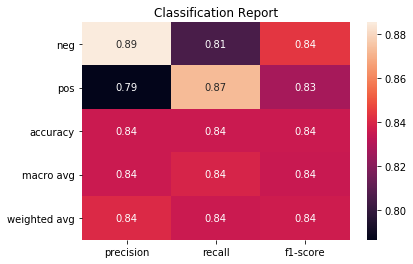

In [0]:
get_predictions_and_accuracy(X_test)

##### Tune Hyperparameters
We will use ParameterSearch since we already have validation set else we would have used GridSearchCV

In [0]:
parameters = {
    'ngram_range': [(1, 1), (1, 2), (1, 3), (2, 3)]
}
parameters = ParameterGrid(parameters)

In [0]:
best_model = Model(None, None, None)
best_accuracy = 0
for parameter in tqdm(list(parameters)):
    pipeline = Pipeline(
        [('tfidf', TfidfVectorizer(ngram_range=parameter['ngram_range'])),
        ('nb', MultinomialNB())])
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_valid)
    accuracy = accuracy_score(y_valid, y_pred)
    print('Accuracy: {:.2f} Parameter: {}'.format(accuracy * 100, parameter['ngram_range']))
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_model = Model(pipeline, y_pred, accuracy)

print('Best Pipeline found: {} with accuracy: {:.2f}%'.format([step[1] for step in best_model.pipeline.steps], best_model.accuracy*100))

Accuracy: 87.26 Parameter: (1, 1)
Accuracy: 88.78 Parameter: (1, 2)
Accuracy: 88.78 Parameter: (1, 3)
Accuracy: 87.04 Parameter: (2, 3)

Best Pipeline found: [TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=1.0, max_features=None,
                min_df=1, ngram_range=(1, 2), norm='l2', preprocessor=None,
                smooth_idf=True, stop_words=None, strip_accents=None,
                sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, use_idf=True, vocabulary=None), MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)] with accuracy: 88.78%


##### Test Set Results

Test Accuracy: 86.2120%
                    neg           pos  accuracy     macro avg  weighted avg
precision      0.899440      0.824800   0.86212      0.862120      0.864906
recall         0.836969      0.891329   0.86212      0.864149      0.862120
f1-score       0.867081      0.856775   0.86212      0.861928      0.862312
support    13433.000000  11567.000000   0.86212  25000.000000  25000.000000


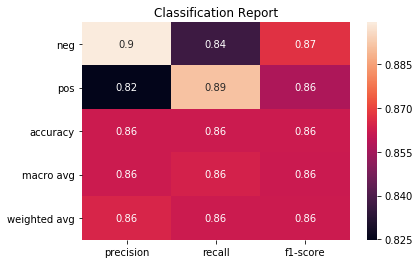

In [0]:
get_predictions_and_accuracy(X_test)

#### 2. Random Forest Classifier

In [0]:
from sklearn.ensemble import RandomForestClassifier

In [0]:
tf = TfidfVectorizer()
tf_x_train = tf.fit_transform(X_train)
accuracy = accuracy_score(RandomForestClassifier().fit(tf_x_train, y_train).predict(tf.transform(X_valid)), y_valid)
print('Base Accuracy: {:.4f}'.format(accuracy * 100))

Base Accuracy: 85.7600


In [0]:
parameters = {
    'ngram_range': [(1, 2)],
    'max_depth': [None],
    'n_estimators': [300, 1000],
    'n_jobs' : [-1]
}

parameters = ParameterGrid(parameters)

In [0]:
best_model = Model(None, None, None)
best_accuracy = 0
for parameter in tqdm(list(parameters)):
    pipeline = Pipeline(
        [('tfidf', TfidfVectorizer(ngram_range=parameter['ngram_range'])),
        ('rfc', RandomForestClassifier(
                    max_depth=parameter['max_depth'],
                    n_estimators=parameter['n_estimators']
                                      ))])
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_valid)
    accuracy = accuracy_score(y_valid, y_pred)
    print('Accuracy: {:.2f} Parameters: {}'.format(accuracy * 100, parameter))
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_model = Model(pipeline, y_pred, accuracy)

print('Best Pipeline found: {} with accuracy: {:.2f}%'.format([step[1] for step in best_model.pipeline.steps], best_model.accuracy*100))

Accuracy: 86.80 Parameters: {'max_depth': None, 'n_estimators': 300, 'n_jobs': -1, 'ngram_range': (1, 2)}
Accuracy: 87.60 Parameters: {'max_depth': None, 'n_estimators': 1000, 'n_jobs': -1, 'ngram_range': (1, 2)}

Best Pipeline found: [TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=1.0, max_features=None,
                min_df=1, ngram_range=(1, 2), norm='l2', preprocessor=None,
                smooth_idf=True, stop_words=None, strip_accents=None,
                sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, use_idf=True, vocabulary=None), RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_i

Test Accuracy: 87.1000%
                    neg           pos  accuracy     macro avg  weighted avg
precision      0.882880      0.859120     0.871      0.871000      0.871282
recall         0.862390      0.880030     0.871      0.871210      0.871000
f1-score       0.872515      0.869449     0.871      0.870982      0.871018
support    12797.000000  12203.000000     0.871  25000.000000  25000.000000


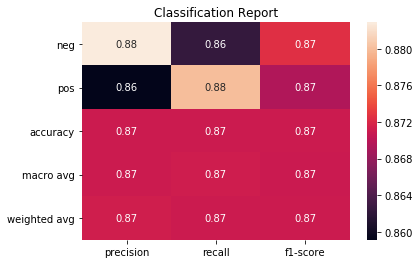

In [0]:
get_predictions_and_accuracy(X_test)

#### 3. SVC

In [0]:
from sklearn.svm import LinearSVC

In [0]:
parameters = {
    'ngram_range': [(1, 2)],
    'penalty': ['l2'],
    'C' : [1.0, 2.0, 3.0]
}

parameters = ParameterGrid(parameters)

In [0]:
best_model = Model(None, None, None)
best_accuracy = 0
for parameter in tqdm(list(parameters)):
    pipeline = Pipeline(
        [('tfidf', TfidfVectorizer(ngram_range=parameter['ngram_range'])),
        ('svc', LinearSVC(penalty=parameter['penalty'],
                          C=parameter['C']))])
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_valid)
    accuracy = accuracy_score(y_valid, y_pred)
    print('Accuracy: {:.2f} Parameters: {}'.format(accuracy * 100, parameter))
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_model = Model(pipeline, y_pred, accuracy)

print('Best Pipeline found: {} with accuracy: {:.2f}%'.format([step[1] for step in best_model.pipeline.steps], best_model.accuracy*100))

Accuracy: 89.88 Parameters: {'C': 1.0, 'ngram_range': (1, 2), 'penalty': 'l2'}
Accuracy: 90.04 Parameters: {'C': 2.0, 'ngram_range': (1, 2), 'penalty': 'l2'}
Accuracy: 90.02 Parameters: {'C': 3.0, 'ngram_range': (1, 2), 'penalty': 'l2'}

Best Pipeline found: [TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=1.0, max_features=None,
                min_df=1, ngram_range=(1, 2), norm='l2', preprocessor=None,
                smooth_idf=True, stop_words=None, strip_accents=None,
                sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, use_idf=True, vocabulary=None), LinearSVC(C=2.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)] with accuracy

Test Accuracy: 89.2440%
                    neg           pos  accuracy     macro avg  weighted avg
precision      0.891200      0.893680   0.89244      0.892440      0.892443
recall         0.893416      0.891469   0.89244      0.892442      0.892440
f1-score       0.892306      0.892573   0.89244      0.892440      0.892440
support    12469.000000  12531.000000   0.89244  25000.000000  25000.000000


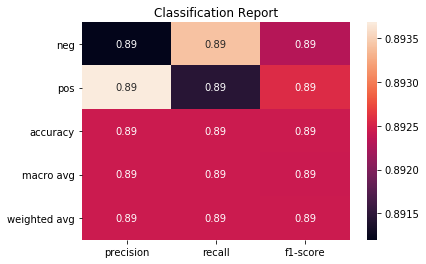

In [0]:
get_predictions_and_accuracy(X_test)

#### 4. SGD Classifier

In [0]:
from sklearn.linear_model import SGDClassifier

In [0]:
parameters = {
    'ngram_range': [(1,1), (1, 2)],
    'penalty': ['l2', 'elasticnet'],
    'alpha': [1e-3, 1e-4],
    'n_jobs' : [-1]
}

parameters = ParameterGrid(parameters)

In [0]:
best_model = Model(None, None, None)
best_accuracy = 0
for parameter in tqdm(list(parameters)):
    pipeline = Pipeline(
        [('tfidf', TfidfVectorizer(ngram_range=parameter['ngram_range'])),
        ('sgd', SGDClassifier(penalty=parameter['penalty'],
                          alpha=parameter['alpha'],
                          n_jobs=parameter['n_jobs']))])
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_valid)
    accuracy = accuracy_score(y_valid, y_pred)
    print('Accuracy: {:.2f} Parameters: {}'.format(accuracy * 100, parameter))
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_model = Model(pipeline, y_pred, accuracy)

print('Best Pipeline found: {} with accuracy: {:.2f}%'.format([step[1] for step in best_model.pipeline.steps], best_model.accuracy*100))

Accuracy: 85.50 Parameters: {'alpha': 0.001, 'n_jobs': -1, 'ngram_range': (1, 1), 'penalty': 'l2'}
Accuracy: 82.84 Parameters: {'alpha': 0.001, 'n_jobs': -1, 'ngram_range': (1, 1), 'penalty': 'elasticnet'}
Accuracy: 82.44 Parameters: {'alpha': 0.001, 'n_jobs': -1, 'ngram_range': (1, 2), 'penalty': 'l2'}
Accuracy: 79.48 Parameters: {'alpha': 0.001, 'n_jobs': -1, 'ngram_range': (1, 2), 'penalty': 'elasticnet'}
Accuracy: 89.50 Parameters: {'alpha': 0.0001, 'n_jobs': -1, 'ngram_range': (1, 1), 'penalty': 'l2'}
Accuracy: 88.90 Parameters: {'alpha': 0.0001, 'n_jobs': -1, 'ngram_range': (1, 1), 'penalty': 'elasticnet'}
Accuracy: 89.02 Parameters: {'alpha': 0.0001, 'n_jobs': -1, 'ngram_range': (1, 2), 'penalty': 'l2'}
Accuracy: 87.88 Parameters: {'alpha': 0.0001, 'n_jobs': -1, 'ngram_range': (1, 2), 'penalty': 'elasticnet'}

Best Pipeline found: [TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
              

Test Accuracy: 88.2080%
                    neg           pos  accuracy     macro avg  weighted avg
precision      0.887440      0.876720   0.88208      0.882080      0.882137
recall         0.878028      0.886220   0.88208      0.882124      0.882080
f1-score       0.882709      0.881445   0.88208      0.882077      0.882083
support    12634.000000  12366.000000   0.88208  25000.000000  25000.000000


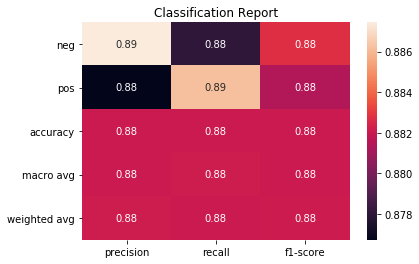

In [0]:
get_predictions_and_accuracy(X_test)

#### 5. XGBoost
Ah! The power of Gradient Boosted tree :D

In [0]:
import xgboost as xgb

In [0]:
parameters = {
    'ngram_range': [(1, 2)],
    'max_depth' : [3, 4, 5],
    'n_estimators' : [100, 150]
}

parameters = ParameterGrid(parameters)

In [0]:
best_model = Model(None, None, None)
best_accuracy = 0
for parameter in tqdm(list(parameters)):
    pipeline = Pipeline(
        [('tfidf', TfidfVectorizer(ngram_range=parameter['ngram_range'])),
        ('xgb', xgb.XGBClassifier(objective="binary:logistic",
            max_depth=parameter['max_depth'],
            n_estimators=parameter['n_estimators']
        ))])
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_valid)
    accuracy = accuracy_score(y_valid, y_pred)
    print('Accuracy: {:.2f} Parameters: {}'.format(accuracy * 100, parameter))
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_model = Model(pipeline, y_pred, accuracy)

print('Best Pipeline found: {} with accuracy: {:.2f}%'.format([step[1] for step in best_model.pipeline.steps], best_model.accuracy*100))

Accuracy: 80.94 Parameters: {'max_depth': 3, 'n_estimators': 100, 'ngram_range': (1, 2)}
Accuracy: 82.40 Parameters: {'max_depth': 3, 'n_estimators': 150, 'ngram_range': (1, 2)}
Accuracy: 81.50 Parameters: {'max_depth': 4, 'n_estimators': 100, 'ngram_range': (1, 2)}
Accuracy: 83.20 Parameters: {'max_depth': 4, 'n_estimators': 150, 'ngram_range': (1, 2)}
Accuracy: 82.24 Parameters: {'max_depth': 5, 'n_estimators': 100, 'ngram_range': (1, 2)}
Accuracy: 83.76 Parameters: {'max_depth': 5, 'n_estimators': 150, 'ngram_range': (1, 2)}

Best Pipeline found: [TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=1.0, max_features=None,
                min_df=1, ngram_range=(1, 2), norm='l2', preprocessor=None,
                smooth_idf=True, stop_words=None, strip_accents=None,
                sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
           

Test Accuracy: 83.8920%
                    neg           pos  accuracy     macro avg  weighted avg
precision      0.816800      0.861040   0.83892      0.838920      0.839899
recall         0.854608      0.824561   0.83892      0.839585      0.838920
f1-score       0.835276      0.842406   0.83892      0.838841      0.838999
support    11947.000000  13053.000000   0.83892  25000.000000  25000.000000


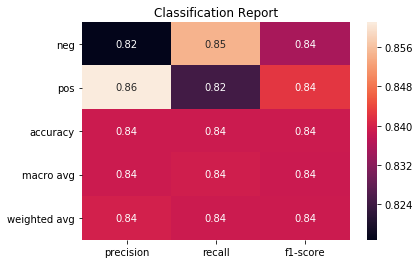

In [0]:
get_predictions_and_accuracy(X_test)

#### 6. LightGBM

In [0]:
import lightgbm as lgbm

In [0]:
parameters = {
    'ngram_range': [(1, 2)],
    "objective": ["binary"],
    "metric": ["binary_logloss"],
    "max_depth" : [-1, 7],
    "num_leaves": [31, 70],
    "verbose": [-1],
    "n_jobs": [-1]
    }
parameters = ParameterGrid(parameters)

In [0]:
best_model = Model(None, None, None)
best_accuracy = 0
for parameter in tqdm(list(parameters)):
    pipeline = Pipeline([('tfidf', TfidfVectorizer(ngram_range=parameter['ngram_range'])),
        ('lgbm', lgbm.LGBMClassifier(
            objective=parameter['objective'],
            metric=parameter['metric'],
            max_depth=parameter['max_depth'],
            num_leaves=parameter['num_leaves'],
            verbose=parameter['verbose']
        ))])
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_valid)
    accuracy = accuracy_score(y_valid, y_pred)
    print('Accuracy: {:.2f} Parameters: {}'.format(accuracy * 100, parameter))
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_model = Model(pipeline, y_pred, accuracy)

print('Best Pipeline found: {} with accuracy: {:.2f}%'.format([step[1] for step in best_model.pipeline.steps], best_model.accuracy*100))

Accuracy: 86.32 Parameters: {'max_depth': -1, 'metric': 'binary_logloss', 'n_jobs': -1, 'ngram_range': (1, 2), 'num_leaves': 31, 'objective': 'binary', 'verbose': -1}
Accuracy: 87.46 Parameters: {'max_depth': -1, 'metric': 'binary_logloss', 'n_jobs': -1, 'ngram_range': (1, 2), 'num_leaves': 70, 'objective': 'binary', 'verbose': -1}
Accuracy: 83.52 Parameters: {'max_depth': 7, 'metric': 'binary_logloss', 'n_jobs': -1, 'ngram_range': (1, 2), 'num_leaves': 31, 'objective': 'binary', 'verbose': -1}
Accuracy: 83.50 Parameters: {'max_depth': 7, 'metric': 'binary_logloss', 'n_jobs': -1, 'ngram_range': (1, 2), 'num_leaves': 70, 'objective': 'binary', 'verbose': -1}

Best Pipeline found: [TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=1.0, max_features=None,
                min_df=1, ngram_range=(1, 2), norm='l2', preprocessor=None,
                smoo

Test Accuracy: 86.9400%
                    neg           pos  accuracy     macro avg  weighted avg
precision      0.868640      0.870160    0.8694      0.869400      0.869401
recall         0.869962      0.868839    0.8694      0.869401      0.869400
f1-score       0.869301      0.869499    0.8694      0.869400      0.869400
support    12481.000000  12519.000000    0.8694  25000.000000  25000.000000


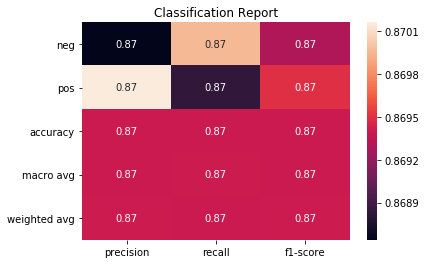

In [0]:
get_predictions_and_accuracy(X_test)

#### Voting Classifier
Merging few of major classifiers and running them on a voting basis

In [0]:
from sklearn.ensemble import VotingClassifier

In [0]:
voting_classifier = VotingClassifier(estimators=[
                        ('nb' , MultinomialNB()),
                        ('rfc', RandomForestClassifier()),
                        ('svc', LinearSVC(penalty='l2', C=0.2)),
                        ('sgd', SGDClassifier(penalty='l2', alpha=0.0001))
                    ])

In [0]:
pipeline = Pipeline([
    ('tfid', TfidfVectorizer()),
    ('vc', voting_classifier)
])
pipeline.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('tfid',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token_pattern='(...
                                                             early_stopping=False,
                                                             epsilon=0.1,
                                                             eta0=0.0,
                                                             fit_intercept

In [0]:
y_pred = pipeline.predict(X_valid)
accuracy = accuracy_score(y_valid, y_pred)
print('Accuracy: {:.2f}'.format(accuracy * 100))
best_model = Model(pipeline, y_pred, accuracy)

Accuracy: 89.10


Test Accuracy: 87.5800%
                    neg           pos  accuracy     macro avg  weighted avg
precision      0.912640      0.838960    0.8758      0.875800      0.878514
recall         0.850011      0.905691    0.8758      0.877851      0.875800
f1-score       0.880213      0.871049    0.8758      0.875631      0.875969
support    13421.000000  11579.000000    0.8758  25000.000000  25000.000000


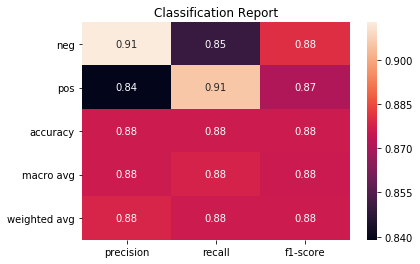

In [0]:
get_predictions_and_accuracy(X_test)

## Deep Neural Network Models

### List of NN Models Implemented



1.   Recurrent Neural Network: Will use Word Embeddings
2.   Fast Text Based Single Pooling Sentimental Analysis
2.   Convolutional Neural Network



**TEST AREA** *IGNORE*

In [0]:
# from torchtext.data import Pipeline
# def remove_stopwords2(text):
#     """Removes Stopwords from the text uses scapy tokenizer little heavy but good"""
#     text = ' '.join([word.text for word in tokenizer(text.text) if word.text not in stopwords])
#     return text
# pipeline = Pipeline(remove_stopwords2)
# TEXT_test = data.Field(preprocessing=pipeline, tokenize=tokenizer)
# LABEL_test = data.LabelField(dtype = torch.float)
# train_data2, test_data2 = datasets.IMDB.splits(TEXT, LABEL)
# train_data.examples[0].text
# [word.text for word in tokenizer(train_data2.examples[0].text.text) if word.text not in stopwords]
# type(tokenizer(train_data2.examples[0].text))
# TEXT_test.preprocess(train_data2.examples[0].text.text)
# Try something like this
# https://medium.com/@sonicboom8/sentiment-analysis-torchtext-55fb57b1fab8

#### 1. Recurrent Neural Network

##### Building Vocabulary

In [0]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [0]:
MAX_VOCAB = 25000
TEXT.build_vocab(train_data,
                 max_size=MAX_VOCAB,
                 vectors='glove.6B.100d',
                 unk_init=torch.Tensor.normal_)

LABEL.build_vocab(train_data)

.vector_cache/glove.6B.zip: 862MB [06:27, 2.22MB/s]                          
100%|█████████▉| 398946/400000 [00:17<00:00, 23477.77it/s]

In [0]:
len(TEXT.vocab)

25002

##### Initializing Iterators

In [0]:
BATCH_SIZE = 128

train_iterator, valid_iterator, test_iterator = data.BucketIterator.splits(
    (train_data, valid_data, test_data),
    batch_size=BATCH_SIZE,
    sort_within_batch=True,
    device=device
)

##### Model Definition

In [0]:
class RNN(nn.Module):

    def __init__(self,vocab_size, embedding_dim, padding_idx, 
                 hidden_dim, n_layer, dropout, output_dim):
        super(RNN, self).__init__()

        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx)
        self.rnn = nn.LSTM(embedding_dim, hidden_dim, num_layers=n_layer, bidirectional=True, dropout=dropout)
        self.fc1 = nn.Linear(hidden_dim*2, output_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, text, text_length):
        embedded = self.embedding(text)
        padded_token = nn.utils.rnn.pack_padded_sequence(embedded, text_length)
        packed_output, (hidden, cell) = self.rnn(padded_token)

        # We can unpack to see just for debug
        output, output_length = nn.utils.rnn.pad_packed_sequence(packed_output)

        hidden = torch.cat((hidden[-2, :, :], hidden[-1, :, :]), dim=1)

        hidden = self.dropout(hidden)

        return self.fc1(hidden) 

##### Initializing Hyperparameters and Model

###### HyperParameters

In [0]:
INPUT_DIM = len(TEXT.vocab)
EMBEDDING_DIM = 100
PADDING_IDX = TEXT.vocab.stoi[TEXT.pad_token]
HIDDEN_DIM = 256
NUM_LAYERS = 2
DROPOUT = 0.7
OUTPUT_DIM = 1



###### Initializing Model

In [0]:
model = RNN(INPUT_DIM, EMBEDDING_DIM, PADDING_IDX, HIDDEN_DIM, NUM_LAYERS, DROPOUT, OUTPUT_DIM)

In [105]:
# Number of Parameters
print('Number of Trainable Parameters: {:,}'.format(sum([p.numel() for p in model.parameters() if p.requires_grad])))

Number of Trainable Parameters: 4,810,857


##### Adding PreTrained Embeddings
Adding Glove Embeddings and Resetting Unk and Pad token embeddings to zero


In [106]:
# Copy Glove Embeddings
model.embedding.weight.data.copy_(TEXT.vocab.vectors)

tensor([[-0.1117, -0.4966,  0.1631,  ...,  1.2647, -0.2753, -0.1325],
        [-0.8555, -0.7208,  1.3755,  ...,  0.0825, -1.1314,  0.3997],
        [ 0.3825,  0.1482,  0.6060,  ...,  0.0589,  0.0911,  0.4728],
        ...,
        [ 0.5443,  0.7859, -0.1652,  ...,  0.5248,  0.7487, -0.5032],
        [-0.5525,  0.3798,  0.7951,  ..., -1.2334,  1.2798, -0.5894],
        [-0.1392,  0.4282,  0.3342,  ...,  0.0850,  0.2070, -0.4701]])

In [0]:
# Set Zero
UNK_IDX = TEXT.vocab.stoi[TEXT.unk_token]

model.embedding.weight.data[UNK_IDX] = torch.zeros(EMBEDDING_DIM)
model.embedding.weight.data[PADDING_IDX] = torch.zeros(EMBEDDING_DIM)

##### Training and Evaluation Methods

In [0]:
def calc_accuracy(prediction, true_output):
    """Calculates accuracy"""
    correct = (torch.round(torch.sigmoid(prediction)) == true_output).float()
    return correct.sum() / len(correct)

In [0]:
def train(model, iterator, optimizer, criterion):
    model.train()
    epoch_loss = 0
    epoch_acc = 0

    for batch in iterator:
        optimizer.zero_grad()
        
        text, text_length = batch.text
        prediction = model(text, text_length).squeeze(1)
        
        loss = criterion(prediction, batch.label)
        acc = calc_accuracy(prediction, batch.label)

        loss.backward()
        optimizer.step()

        epoch_loss += loss
        epoch_acc += acc
    
    return epoch_loss/len(iterator) , epoch_acc / len(iterator)

In [0]:
def evaluate(model, iterator, criterion):
    model.eval()
    epoch_loss = 0
    epoch_acc = 0
    with torch.no_grad():
        for batch in iterator:
            text, text_length = batch.text
            prediction  = model(text, text_length).squeeze(1)
            loss = criterion(prediction, batch.label)
            acc = calc_accuracy(prediction, batch.label)

            epoch_loss += loss
            epoch_acc += acc

    return epoch_loss/len(iterator), epoch_acc/len(iterator)



##### Training and Evaluating Model

In [0]:
optimizer = optim.Adam(model.parameters(), weight_decay=0.001)
criterion = nn.BCEWithLogitsLoss().to(device)
model = model.to(device)

In [0]:
EPOCHS = 10

In [113]:
for i in tqdm(range(EPOCHS)):
    train_loss, train_acc = train(model, train_iterator, optimizer, criterion )
    valid_loss, valid_acc = evaluate(model, valid_iterator, criterion)

    print("Epoch: [{:02} / {:02}]  \tTraining Loss: {:.4f} \t\tTraining Accuracy: {:.4f}".format(i+1, EPOCHS, train_loss, train_acc))
    print("Epoch: [{:02} / {:02}] \tValidation Loss: {:.4f} \tValidation Accuracy: {:.4f}".format(i+1, EPOCHS, valid_loss, valid_acc))

Epoch: [01 / 10]  	Training Loss: 0.5093 		Training Accuracy: 0.7431
Epoch: [01 / 10] 	Validation Loss: 0.4205 	Validation Accuracy: 0.7984
Epoch: [02 / 10]  	Training Loss: 0.3153 		Training Accuracy: 0.8690
Epoch: [02 / 10] 	Validation Loss: 0.3157 	Validation Accuracy: 0.8746
Epoch: [03 / 10]  	Training Loss: 0.2959 		Training Accuracy: 0.8774
Epoch: [03 / 10] 	Validation Loss: 0.4543 	Validation Accuracy: 0.7969
Epoch: [04 / 10]  	Training Loss: 0.2130 		Training Accuracy: 0.9170
Epoch: [04 / 10] 	Validation Loss: 0.3186 	Validation Accuracy: 0.8838
Epoch: [05 / 10]  	Training Loss: 0.1302 		Training Accuracy: 0.9546
Epoch: [05 / 10] 	Validation Loss: 0.3318 	Validation Accuracy: 0.8828
Epoch: [06 / 10]  	Training Loss: 0.0885 		Training Accuracy: 0.9700
Epoch: [06 / 10] 	Validation Loss: 0.4079 	Validation Accuracy: 0.8709
Epoch: [07 / 10]  	Training Loss: 0.0681 		Training Accuracy: 0.9784
Epoch: [07 / 10] 	Validation Loss: 0.4582 	Validation Accuracy: 0.8828
Epoch: [08 / 10]  	T

In [117]:
test_loss, test_acc = evaluate(model, test_iterator, criterion)
print('Test Loss: {:.4f} \tTest Accuracy: {:.2f}%'.format(valid_loss, valid_acc*100))

Test Loss: 0.5847 	Test Accuracy: 87.97%


##### Adding Regularization 
L2 Norm will be added by adding weight decay in Optimizer

In [120]:
model = RNN(INPUT_DIM, EMBEDDING_DIM, PADDING_IDX, HIDDEN_DIM, NUM_LAYERS, DROPOUT, OUTPUT_DIM)
optimizer = optim.Adam(model.parameters(), weight_decay=0.0001)
criterion = nn.BCEWithLogitsLoss().to(device)
model = model.to(device)

for i in tqdm(range(EPOCHS)):
    train_loss, train_acc = train(model, train_iterator, optimizer, criterion )
    valid_loss, valid_acc = evaluate(model, valid_iterator, criterion)

    print("Epoch: [{:02} / {:02}]  \tTraining Loss: {:.4f} \t\tTraining Accuracy: {:.4f}".format(i+1, EPOCHS, train_loss, train_acc))
    print("Epoch: [{:02} / {:02}] \tValidation Loss: {:.4f} \tValidation Accuracy: {:.4f}".format(i+1, EPOCHS, valid_loss, valid_acc))

Epoch: [01 / 10]  	Training Loss: 0.6125 		Training Accuracy: 0.6520
Epoch: [01 / 10] 	Validation Loss: 0.5299 	Validation Accuracy: 0.7303
Epoch: [02 / 10]  	Training Loss: 0.5096 		Training Accuracy: 0.7495
Epoch: [02 / 10] 	Validation Loss: 0.4595 	Validation Accuracy: 0.7783
Epoch: [03 / 10]  	Training Loss: 0.4296 		Training Accuracy: 0.8024
Epoch: [03 / 10] 	Validation Loss: 0.4616 	Validation Accuracy: 0.7785
Epoch: [04 / 10]  	Training Loss: 0.4735 		Training Accuracy: 0.7781
Epoch: [04 / 10] 	Validation Loss: 0.4263 	Validation Accuracy: 0.8217
Epoch: [05 / 10]  	Training Loss: 0.3734 		Training Accuracy: 0.8378
Epoch: [05 / 10] 	Validation Loss: 0.3793 	Validation Accuracy: 0.8314
Epoch: [06 / 10]  	Training Loss: 0.3098 		Training Accuracy: 0.8724
Epoch: [06 / 10] 	Validation Loss: 0.3591 	Validation Accuracy: 0.8445
Epoch: [07 / 10]  	Training Loss: 0.2950 		Training Accuracy: 0.8833
Epoch: [07 / 10] 	Validation Loss: 0.3591 	Validation Accuracy: 0.8434
Epoch: [08 / 10]  	T

In [123]:
test_loss, test_acc = evaluate(model, test_iterator, criterion)
print('Test Loss: {:.4f} \tTest Accuracy: {:.2f}%'.format(test_loss, test_acc*100))

Test Loss: 0.3650 	Test Accuracy: 85.47%


#### Fast Text Based Sentimental Analysis

##### Generating N-grams

In [0]:
def generate_n_grams(sentence, n=2):
    grams =  set(zip(*[x[i:] for i in range(n)]))
    for gram in grams:
        sentence.append(' '.join(gram))
    return sentence

In [14]:
# Testing Method
x = ['hello', 'world', 'how', 'are', 'you']
generate_n_grams(x, 2)

['hello',
 'world',
 'how',
 'are',
 'you',
 'are you',
 'world how',
 'how are',
 'hello world']

##### Load Data as BiGrams

In [0]:
MAX_VOCAB = 25000

TEXT_FT = data.Field(tokenize=tokenizer, preprocessing=generate_n_grams)
LABEL_FT = data.LabelField(dtype=torch.float)

train_data_FT, test_data_FT = datasets.IMDB.splits(TEXT_FT, LABEL_FT)
train_data_FT, valid_data_FT = train_data_FT.split(random_state=random.seed(SEED))


TEXT_FT.build_vocab(train_data_FT, 
                    max_size=MAX_VOCAB,
                    vectors='glove.6B.100d',
                    unk_init=torch.Tensor.normal_)
LABEL_FT.build_vocab(train_data_FT)

##### Create Iterators

In [0]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

BATCH_SIZE = 128
train_iter_FT, valid_iter_FT, test_iter_FT = data.BucketIterator.splits(
    (train_data_FT, valid_data_FT, test_data_FT),
    batch_size=BATCH_SIZE,
    device=device
)

##### Defining Model

In [0]:
class FastText(nn.Module):

    def __init__(self, vocab_size, embeddding_dim, padding_idx, output_dim):
        super(FastText, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embeddding_dim, padding_idx)
        self.fc = nn.Linear(embeddding_dim, output_dim)
    
    def forward(self, x):
        x = self.embedding(x)
        x = x.permute(1, 0, 2)
        x = F.avg_pool2d(x, (x.shape[1], 1)).squeeze(1)
        return self.fc(x)

##### HyperParameters

In [0]:
INPUT_DIM_FT = len(TEXT_FT.vocab)
EMBEDDING_DIM_FT = 100
PADDING_IDX_FT = TEXT_FT.vocab.stoi[TEXT_FT.pad_token]
OUTPUT_DIM_FT = 1


In [0]:
model_ft = FastText(INPUT_DIM_FT, EMBEDDING_DIM_FT, PADDING_IDX_FT, OUTPUT_DIM_FT)

In [68]:
print('Number of Parameters: {:,}'.format(sum([p.numel() for p in model_ft.parameters() if p.requires_grad])))

Number of Parameters: 2,500,301


##### Adding PreTrained Embedding

In [69]:
model_ft.embedding.weight.data.copy_(TEXT_FT.vocab.vectors)

tensor([[ 2.2200e-01,  7.3758e-02,  1.0746e+00,  ..., -7.5162e-01,
          5.6054e-01,  8.6046e-01],
        [ 1.4007e+00, -1.0216e+00, -5.1132e-01,  ..., -1.5382e+00,
          8.6998e-02, -6.7848e-01],
        [ 3.8251e-01,  1.4821e-01,  6.0601e-01,  ...,  5.8921e-02,
          9.1112e-02,  4.7283e-01],
        ...,
        [-4.5144e-01,  5.4495e-01,  6.5739e-01,  ..., -8.7689e-01,
          5.6956e-01, -7.0563e-01],
        [ 2.3987e-01, -1.4909e-01, -4.3024e-01,  ...,  8.1191e-05,
         -8.2991e-01,  7.1019e-01],
        [-1.3179e-02,  9.1583e-01, -1.5579e-01,  ..., -4.9257e-01,
          4.0668e-01,  2.0437e-01]])

In [0]:
# Unknown word embeddings zero
model_ft.embedding.weight.data[TEXT_FT.vocab.stoi[TEXT_FT.unk_token]] = torch.zeros(EMBEDDING_DIM_FT)
model_ft.embedding.weight.data[PADDING_IDX_FT] = torch.zeros(EMBEDDING_DIM_FT)

##### Training Methods

In [0]:
def train(model, iterator, optimizer, criterion):
    model.train()
    epoch_loss = 0
    epoch_acc = 0

    for batch in iterator:
        optimizer.zero_grad()
        
        text = batch.text
        prediction = model(text).squeeze(1)
        
        loss = criterion(prediction, batch.label)
        acc = calc_accuracy(prediction, batch.label)

        loss.backward()
        optimizer.step()

        epoch_loss += loss
        epoch_acc += acc
    
    return epoch_loss/len(iterator) , epoch_acc / len(iterator)

In [0]:
def evaluate(model, iterator, criterion):
    model.eval()
    epoch_loss = 0
    epoch_acc = 0
    with torch.no_grad():
        for batch in iterator:
            text = batch.text
            prediction  = model(text).squeeze(1)
            loss = criterion(prediction, batch.label)
            acc = calc_accuracy(prediction, batch.label)

            epoch_loss += loss
            epoch_acc += acc

    return epoch_loss/len(iterator), epoch_acc/len(iterator)



In [0]:
optimizer = optim.Adam(model_ft.parameters())

In [0]:
criterion = nn.BCEWithLogitsLoss()

In [0]:
model_ft = model_ft.to(device)
criterion = criterion.to(device)

##### Training and Evaluating Model

In [76]:
EPOCHS = 10

for i in range(EPOCHS):
    train_loss, train_acc = train(model_ft, train_iter_FT, optimizer, criterion)
    valid_loss, valid_acc = evaluate(model_ft, valid_iter_FT, criterion)

    
    print("Epoch: [{:02} / {:02}]  \tTraining Loss: {:.4f} \t\tTraining Accuracy: {:.4f}".format(i+1, EPOCHS, train_loss, train_acc))
    print("Epoch: [{:02} / {:02}] \tValidation Loss: {:.4f} \tValidation Accuracy: {:.4f}".format(i+1, EPOCHS, valid_loss, valid_acc))

Epoch: [01 / 10]  	Training Loss: 0.6873 		Training Accuracy: 0.5894
Epoch: [01 / 10] 	Validation Loss: 0.6377 	Validation Accuracy: 0.6963
Epoch: [02 / 10]  	Training Loss: 0.6598 		Training Accuracy: 0.7337
Epoch: [02 / 10] 	Validation Loss: 0.5136 	Validation Accuracy: 0.8134
Epoch: [03 / 10]  	Training Loss: 0.6058 		Training Accuracy: 0.8099
Epoch: [03 / 10] 	Validation Loss: 0.4072 	Validation Accuracy: 0.8334
Epoch: [04 / 10]  	Training Loss: 0.5368 		Training Accuracy: 0.8343
Epoch: [04 / 10] 	Validation Loss: 0.3647 	Validation Accuracy: 0.8461
Epoch: [05 / 10]  	Training Loss: 0.4736 		Training Accuracy: 0.8613
Epoch: [05 / 10] 	Validation Loss: 0.3595 	Validation Accuracy: 0.8599
Epoch: [06 / 10]  	Training Loss: 0.4195 		Training Accuracy: 0.8773
Epoch: [06 / 10] 	Validation Loss: 0.3636 	Validation Accuracy: 0.8688
Epoch: [07 / 10]  	Training Loss: 0.3762 		Training Accuracy: 0.8894
Epoch: [07 / 10] 	Validation Loss: 0.3775 	Validation Accuracy: 0.8757
Epoch: [08 / 10]  	T

In [79]:
test_loss, test_acc = evaluate(model_ft, test_iter_FT, criterion)
print('Test Loss: {:.4f} \tTest Accuracy: {:.2f}%'.format(test_loss, test_acc*100))

Test Loss: 0.4635 	Test Accuracy: 87.56%
